## Import libraries

In [1]:
!pip install matplotlib

In [2]:
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
from pprint import pprint
warnings.filterwarnings("ignore")

### Convert data from CSV to Numpy Array

In [236]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('indonesian'))
# print(f"STOPWORDS:\n {STOPWORDS}")

def clean_text(text):
#     print(f"\n\nOriginal Text: {text}")
    text = text.lower()
#     print(f"\nCase Lowered Text: {text}")
    text = re.sub(r'[^a-z\s]', '', text)
#     print(f"\nRegexed Text: {text}")
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
#     print(f"\nStopwords Removed Text: {text}")
    return text

def tokenize(text, word_to_idx):
    tokens = []
    for word in text.split():
        if word in word_to_idx:
            tokens.append(word_to_idx[word])
        else:
            tokens.append(0)
    return tokens

def pad_and_truncate(messages, max_length=30):
    features = np.zeros((len(messages), max_length), dtype=int)
#     pprint(f"Messages: {messages}\nFeatures: {features}")
    for i, sms in enumerate(messages):
#         print(f"\ni: {i}\nSMS:{sms}")
        if len(sms):
            features[i, -len(sms):] = sms[:max_length]
    return features


if __name__ == '__main__':
    data = pd.read_csv('dataset_sms_spam_v1.csv', sep=',', names=['Teks', 'Label'])
    data = data.sample(frac = 1)
    #Lowercase, remove unnecessary char with regex, remove stop words
    data.Teks = data.Teks.apply(clean_text)
#     print(data.Teks)
    words = set((' '.join(data.Teks)).split())
#     print(words)
    word_to_idx = {word: i for i, word in enumerate(words, start=1)}
#     pprint(word_to_idx)
    tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
#     print(tokens)
    inputs = pad_and_truncate(tokens)
#     pprint(inputs)
    labels = np.array((data.Label == '1').astype(int))

    np.save('labels.npy', labels)
    np.save('inputs.npy', inputs)

[[   0    0    0 ...  404  786 2248]
 [   0    0    0 ...  631 2273 2273]
 [   0    0    0 ...    0  309 3371]
 ...
 [   0    0    0 ... 2926 3201 3512]
 [   0    0    0 ... 4036 1153 1741]
 [   0    0    0 ...  141  649 2580]]


## Loading data

In [4]:
inputs = np.load('inputs.npy')
labels = np.load('labels.npy')

In [5]:
VOCAB_SIZE = int(inputs.max()) + 1

## Training model with Federated learning

### Training and model hyperparameters

In [6]:
# Training params
EPOCHS = 15
CLIP = 5 # gradient clipping - to avoid gradient explosion (frequent in RNNs)
lr = 0.1
BATCH_SIZE = 32

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

### Initiating virtual workers with Pysyft

In [7]:
import syft as sy

In [8]:
labels = torch.tensor(labels)
inputs = torch.tensor(inputs)

# splitting training and test data
# 20% of the data will be for Tests.
pct_test = 0.2

#20% of total data
pct_test_count = -int(len(labels)*pct_test)

# Get 80% of Train LABELS from left.
train_labels = labels[:pct_test_count]
print(f"Train Labels: [:{pct_test_count}]")

# Get 80% of Train INPUTS from left.
train_inputs = inputs[:pct_test_count]
print(f"Train Inputs: [:{pct_test_count}]")

# Get the rest of the LABEL data for test on the right (20%) 
test_labels = labels[pct_test_count:]
print(f"Test Labels: [{pct_test_count}:]")

# Get the rest of the INPUT data for test on the right (20%)
test_inputs = inputs[pct_test_count:]
print(f"Test Inputs: [{pct_test_count}:]")

print(f"Length Labels: {len(labels)}")
print(f"20% of Length Labels: {len(labels)*pct_test}")

Train Labels: [:-228]
Train Inputs: [:-228]
Test Labels: [-228:]
Test Inputs: [-228:]
Length Labels: 1144
20% of Length Labels: 228.8


In [9]:
# Hook that extends the Pytorch library to enable all computations with pointers of tensors sent to other workers
hook = sy.TorchHook(torch)

# Creating 2 virtual workers
bob = sy.VirtualWorker(hook, id="bob")
anne = sy.VirtualWorker(hook, id="anne")

# threshold indexes for dataset split (one half for Bob, other half for Anne)
train_idx = int(len(train_labels)/2)
test_idx = int(len(test_labels)/2)

# Sending toy datasets to virtual workers
bob_train_dataset = sy.BaseDataset(train_inputs[:train_idx], train_labels[:train_idx]).send(bob)
anne_train_dataset = sy.BaseDataset(train_inputs[train_idx:], train_labels[train_idx:]).send(anne)
bob_test_dataset = sy.BaseDataset(test_inputs[:test_idx], test_labels[:test_idx]).send(bob)
anne_test_dataset = sy.BaseDataset(test_inputs[test_idx:], test_labels[test_idx:]).send(anne)

# Creating federated datasets, an extension of Pytorch TensorDataset class
federated_train_dataset = sy.FederatedDataset([bob_train_dataset, anne_train_dataset])
federated_test_dataset = sy.FederatedDataset([bob_test_dataset, anne_test_dataset])

# Creating federated dataloaders, an extension of Pytorch DataLoader class
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
federated_test_loader = sy.FederatedDataLoader(federated_test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [10]:
from handcrafted_GRU import GRU

In [11]:
# Initiating the model
model = GRU(vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)

### Training

For now, PySyft does not support optimizers with momentum. Therefore, we are going to stick with the classical [Stochastic Gradient Descent](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) optimizer.

As our task consists of a binary classification, we are going to use the [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss).

In [12]:
# Defining loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

For each epoch we are going to compute the training and validations losses, as well as the [Area Under the ROC Curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) score due to the fact that the target dataset is unbalaced (only 13% of labels are positive).

In [13]:
train_losses = []
test_losses = []
for e in range(EPOCHS):
    
    ######### Training ##########
    
    losses = []
    # Batch loop
    for inputs, labels in federated_train_loader:
        # Location of current batch
        worker = inputs.location
        # Initialize hidden state and send it to worker
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)
        # Send model to current worker
        model.send(worker)
        # Setting accumulated gradients to zero before backward step
        optimizer.zero_grad()
        # Output from the model
        output, _ = model(inputs.to(torch.long), h)
        # Calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # Clipping the gradient to avoid explosion
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        # Backpropagation step
        optimizer.step() 
        # Get the model back to the local worker
        model.get()
        losses.append(loss.get())
    
    ######## Evaluation ##########
    
    # Model in evaluation mode
    model.eval()

    with torch.no_grad():
        test_preds = []
        test_labels_list = []
        eval_losses = []

        for inputs, labels in federated_test_loader:
            # get current location
            worker = inputs.location
            # Initialize hidden state and send it to worker
            h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)    
            # Send model to worker
            model.send(worker)

            output, _ = model(inputs.to(torch.long), h)
            loss = criterion(output.squeeze(), labels.float())
            eval_losses.append(loss.get())
            preds = output.squeeze().get()
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.get().numpy().astype(int))
            # Get the model back to the local worker
            model.get()

    score = roc_auc_score(test_labels_list, test_preds)

    train_loss = sum(losses)/len(losses)
    eval_loss = sum(eval_losses)/len(eval_losses)
    train_losses.append(train_loss.item())
    test_losses.append(eval_loss.item())
    
    print("Epoch {}/{}...  \
    AUC: {:.3%}...  \
    Training loss: {:.5f}...  \
    Validation loss: {:.5f}".format(e+1, EPOCHS, score, train_loss, eval_loss))
    
    model.train()

Epoch 1/15...      AUC: 52.812%...      Training loss: 0.68680...      Validation loss: 0.63892
Epoch 2/15...      AUC: 56.069%...      Training loss: 0.61091...      Validation loss: 0.62165
Epoch 3/15...      AUC: 58.608%...      Training loss: 0.57065...      Validation loss: 0.60373
Epoch 4/15...      AUC: 61.021%...      Training loss: 0.55683...      Validation loss: 0.59661
Epoch 5/15...      AUC: 63.021%...      Training loss: 0.54130...      Validation loss: 0.60670
Epoch 6/15...      AUC: 64.322%...      Training loss: 0.51874...      Validation loss: 0.59760
Epoch 7/15...      AUC: 65.776%...      Training loss: 0.50452...      Validation loss: 0.58857
Epoch 8/15...      AUC: 67.049%...      Training loss: 0.48522...      Validation loss: 0.57101
Epoch 9/15...      AUC: 68.736%...      Training loss: 0.45961...      Validation loss: 0.56625
Epoch 10/15...      AUC: 69.705%...      Training loss: 0.44229...      Validation loss: 0.55821
Epoch 11/15...      AUC: 70.979%...    

### Plot Losses

Train Losses: [0.6868049502372742, 0.6109057664871216, 0.570647656917572, 0.5568309426307678, 0.5412998199462891, 0.5187394022941589, 0.5045201778411865, 0.48522427678108215, 0.45960840582847595, 0.4422871172428131, 0.42914000153541565, 0.3995884656906128, 0.3879609704017639, 0.36592942476272583, 0.34456393122673035]


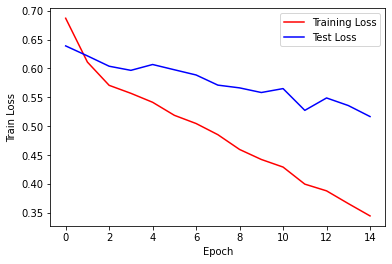

In [42]:
print(f"Train Losses: {train_losses}")
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'b')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

### Saving model for inference

In [44]:
# Save
PATH = "state_dict_model.pt"
torch.save(model.state_dict(), PATH)

# Load Model
# Init
model = GRU(vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
model.load_state_dict(torch.load(PATH))
model.eval()

GRU(
  (dropout): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(4174, 50)
  (gru_cell): GRUCell(
    (fc_ir): Linear(in_features=50, out_features=10, bias=True)
    (fc_hr): Linear(in_features=10, out_features=10, bias=True)
    (fc_iz): Linear(in_features=50, out_features=10, bias=True)
    (fc_hz): Linear(in_features=10, out_features=10, bias=True)
    (fc_in): Linear(in_features=50, out_features=10, bias=True)
    (fc_hn): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Ask for input and pre-process text

In [275]:
text = "bRuH anda ganteng dapet 50 juta broOoOO"
text = clean_text(text)
print(text)
words = text.split()
# print(words)
words = set((' '.join(words)).split())
token_holder = []
tokens = tokenize(text, word_to_idx)
# print(tokens)
# print(word_to_idx)
token_holder.append(tokens)
inference_input = pad_and_truncate(token_holder)
# print(f"\nPadded Inputs: {inference_input}")

bruh ganteng dapet juta brooooo


In [266]:
h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(anne)
output, _ = model(inference_input.to(torch.long), h)

AttributeError: 'numpy.ndarray' object has no attribute 'to'